# The Self-Attention Mechanism

## Recalling previous lessons

When we go from sequences of word embeddings to a document-wise vector representation that can be classified, we have to somehow summarize a sequence of vectors into a single vector. So far, what we have been doing is:

1. Get one embedding per word ($\mathbb{t \times n}$, where $t$ is the sequence length and $n$ is the embedding dimension),
1. Calculate the timewise mean of the words ($\mathbb{1 \times n}$)
1. Proceed to classification with our Residual MLP modules

This is something like this:


<div class="mermaid">
flowchart LR;
    I((Text)) --> Tokenizer --> Embedding --> MLP["MLP with residual"] --> S["Summarizer
    (Mean)"] --> CLS["Classifier
    (Logistic Regression)"] --> y((Output));
</div>

**Exercise**

Now, reflect on this functioning. Which of the problems of the traditional bag-of-words approach is solved by using this idea?

<details>
<summary>Check an answer here</summary>
The embeddings in this approach mitigate the need for larger datasets and tend to enable classifiers that require less data for training. However, the summarization using the mean totally disregards the order of the words - essentially, we are doing a glorified bag-of-words modelling in an embedding space, which, albeit cool, addresses none of the issues of Bag-of-Words.
</details>

## Analysis: words with no order

The model SimpleClassifier below implements a classifier following the exact flowchart as above. Execute this code. Why is the loss not decreasing very much? Hint: see the

<details>
<summary>
Expand for answer
</summary>
The dataset has four data points. However, due to using the mean as an aggregator, the embeddings for items 1 and 2 are strictly the same, and the embeddings for 3 and 4 are also the same. However, they have opposite labels, and the gradients "pulling" the classifier to each direction, and the tendency is that both embeddings (for 1/2 and 3/4) will have probability 0.5 of belonging to each class.
</details>



In [19]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(20)

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.nonlinearity = nn.ReLU()

        # Initialize weights to identity and biases to zero
        nn.init.eye_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.eye_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        residual = x
        x = self.nonlinearity(self.fc1(x))
        x = self.fc2(x)
        x += residual  # Add the residual connection
        return x

class MeanClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.r1 = ResidualBlock(embedding_dim)
        self.clf = nn.Linear(embedding_dim, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.r1(x)
        x = torch.mean(x, dim=1)
        x = self.clf(x)
        return x

In [21]:
# Dataset
X = torch.tensor([
    [0, 1, 2],
    [2, 1, 0],
    [1, 3, 4],
    [4, 3, 1],
])

y = torch.tensor([
    [1.],
    [0.],
    [1.],
    [0.],
])

In [22]:
def train_one_epoch(model, optimizer, x, y):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    loss = F.binary_cross_entropy_with_logits(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [23]:
model = MeanClassifier(vocab_size=5, embedding_dim=2)
optimizer = optim.SGD(model.parameters(), lr=1e-2) # lr is the learning rate - this is our alpha

print("Entering loop")
# And now, this is the training loop:
losses = []
for epoch in tqdm(range(1000)):
    loss = train_one_epoch(model, optimizer, X, y)
    losses.append(loss)

Entering loop


100%|██████████| 1000/1000 [00:01<00:00, 825.46it/s]


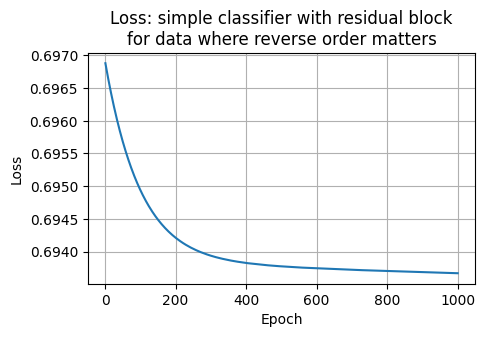

In [24]:
import matplotlib.pyplot as plt

# Plot losses over epochs
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss: simple classifier with residual block\nfor data where reverse order matters')
plt.grid(True)
plt.show()

## Positional encoding

One possible solution to use the order of words is to encode the token positions (that is, literally their index in the input sequence) as embeddings, and then adding that embedding to the word embeddings.

This would lead to a solution like this:

The proposed solution for this is to use an auxiliary sequence of tokens that represents the position of each word in the sequence. Then, each of these "position tokens" receives an embedding (this could be a trained embedding, although the transformer paper uses a [pre-defined cosine-sine embedding](https://arxiv.org/abs/1706.03762) - they both seem to work fine). This position encodings are added to the word embeddings and the result of this operation is, itself, propagated as the input of the network, as in:


<div class="mermaid">
flowchart LR;
    I((Text)) --> Tokenizer --> E1["Embedding"] --> ADD((ADD));
    P((Position)) --> E2["Embedding"] --> ADD;
    ADD --> MLP["MLP with residual"];
    MLP --> S["Mean"];
    S --> CLS["Classifier"];
    CLS --> y((Output));
</div>


**Exercise**

Which of the limitations of Bag-of-Words is solved by positional encoding? Which limitations still exist?

<details>
<summary>
An answer is here
</summary>
Bag-of-words completely disregards the order of words. Likewise, a simple classifier with embeddings and mean also disregards word order. However, a positional encoder is able to identify that reversed sequences can mean different things. However, we cannot yet differentiate changes in the word meaning due to their relative positions with respect to other words.
</details>

### Example: positional encoder

Let's see this phenomenon in action.

In [25]:
class ClassifierWithPositionEncoding(nn.Module):
    def __init__(self, vocab_size, seq_len, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.position_embedding = nn.Embedding(
            num_embeddings=seq_len,  # Assuming max sequence length of 100
            embedding_dim=embedding_dim
        )
        self.r1 = ResidualBlock(embedding_dim)
        self.clf = nn.Linear(embedding_dim, 1)
        
    def forward(self, x):
        pos_enc = self.position_embedding(torch.arange(x.size(1)))
        x_embeddings = self.embedding(x)
        x = x_embeddings + pos_enc
        x = self.r1(x)
        x = torch.mean(x, dim=1)
        x = self.clf(x)
        return x



In [26]:
model1 = ClassifierWithPositionEncoding(vocab_size=5, seq_len=3, embedding_dim=2)
optimizer1 = optim.Adam(model1.parameters(), lr=1e-2) # lr is the learning rate - this is our alpha
model2 = MeanClassifier(vocab_size=5, embedding_dim=2)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-2) # lr is the learning rate - this is our alpha

print("Entering loop")
# And now, this is the training loop:
losses1 = []
losses2 = []
for epoch in tqdm(range(1000)):
    loss1 = train_one_epoch(model1, optimizer1, X, y)
    losses1.append(loss1)
    loss2 = train_one_epoch(model2, optimizer2, X, y)
    losses2.append(loss2)

Entering loop


100%|██████████| 1000/1000 [00:03<00:00, 282.66it/s]


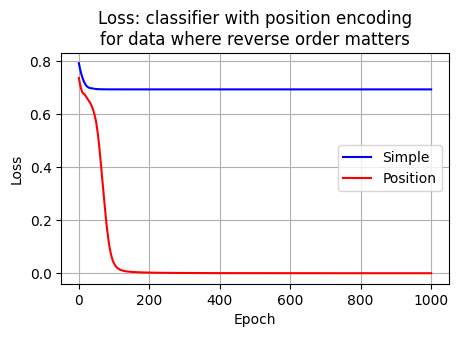

In [27]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(losses2) + 1), losses2, 'b', label='Simple')
plt.plot(range(1, len(losses1) + 1), losses1, 'r', label='Position')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss: classifier with position encoding\nfor data where reverse order matters')
plt.grid(True)
plt.legend()
plt.show()


**Exercise**

<details>
<summary>
Why do we need the residual block in this classifier?
</summary>
We need the ability to apply different transformations to different regions of our latents spaces so that the combination of word embeddings and position embeddings can be meaningful.
</details>

# Self-Attention

If you were not living under a rock in the last few years, you probably heard about something called a "transformer". This is a neural network topology made famous in an article called [Attention is All you Need](https://arxiv.org/abs/1706.03762) (which revolutionized both how we model neural networks for NLP, and how we give titles to our papers on the topic). The paper discusses many ingenious mechanisms, some of which we will discuss now.

## The base idea of attention

In the [Attention paper, Vaswani and their colleagues](https://arxiv.org/abs/1706.03762) observed that this is (at least in a metaphorical sense) similar to calculate a weighted average of the inputs, where weights represent the relevance of each input. Also, they observed that recurrent networks (even LSTMs) tend to give more relevance to words that are close by, even if they can potentially draw information from long distances - and this is not something desireable. Hence, they came with a clever solution.

Their solution starts with calculating the pairwise similarity between each item in the input (or: between each word embedding). For such, they use the inner product between each word, or simply:

$$
S = X X^T
$$

, where $X \in \mathbb{R}^{T \times D}$ contains $T$ word embeddings with dimension $D$.

The result $S \in \mathbb{R}^{T \times T}$ indicates the similarity between each pair of words in the sequence.

After that, $S$ is divided by $\sqrt{D}$ as a form of normalization, that is, this avoids finding larger values if the embedding dimension changes.

Finally, they normalize each line of $S$ using a softmax function, which transforms each line of $S$ into a probability distribution (that is, it sums to $1$).

At the end of this process, they have a weight matrix (they don't actually call it a weight matrix, but I am doing so):

$$
W = \text{softmax} (XX^T/\sqrt{D})
$$

At this point, each element $w_{t1,t2}$ of $W$ contains the weight given to token $t2$ at time $t1$. To apply these weights, they multiply $W$ by $X$, so that:

$$
Y = WX = \text{softmax} (XX^T/\sqrt{D})X.
$$

Thus, $Y \in \mathbb{R}^{T \times D}$ contains a transformation of the sequence (this is not stated, but I guess the name "transformer" comes from this idea) where each output is a weighted mean of the inputs. The weights can be seen as the "relevance" of each input, that is, points to which the system should pay *attention* - henceforth, *attention is all you need*.

Now, our structure looks like this:

<div class="mermaid">
flowchart LR;
    I((Text)) --> Tokenizer --> E1["Embedding"] --> ADD((ADD));
    P((Position)) --> E2["Embedding"] --> ADD;
    ADD --> MHE["Self-attention"];
    MHE --> MLP["MLP with residual"];
    MLP --> S["Mean"];
    S --> CLS["Classifier"];
    CLS --> y((Output));
</div>




### Example

Suppose we have a phrase such as "Trees, flowers, university, classroom". It is reasonable to suppose that the embeddings of "Trees" and "flowers" is somewhat similar, but "university" has an embedding that is less similar. Hence we could have embeddings $X$ like:

$$
X = \begin{bmatrix} 0.7 & 0.6 \\
                    0.6 & 0.7 \\
                    -1.0 & 0 \\
                    -0.9 & -0.1
\end{bmatrix}
$$

Let's follow each operation we have proposed here:

In [28]:
X = torch.tensor([
    [0.7, 0.6],
    [0.6, 0.7],
    [-1.0, 0.0],
    [-0.9, -0.1],
], )

S = X @ X.T
print(S)


tensor([[ 0.8500,  0.8400, -0.7000, -0.6900],
        [ 0.8400,  0.8500, -0.6000, -0.6100],
        [-0.7000, -0.6000,  1.0000,  0.9000],
        [-0.6900, -0.6100,  0.9000,  0.8200]])


In [29]:
W = torch.softmax(S/torch.sqrt(torch.tensor([3])), dim=1)
print(W)

tensor([[0.3554, 0.3533, 0.1452, 0.1461],
        [0.3479, 0.3499, 0.1515, 0.1506],
        [0.1380, 0.1462, 0.3682, 0.3476],
        [0.1440, 0.1508, 0.3607, 0.3444]])


In [30]:
Y = W @ X
print(Y)


tensor([[ 0.1841,  0.4460],
        [ 0.1664,  0.4387],
        [-0.4967,  0.1504],
        [-0.4793,  0.1576]])


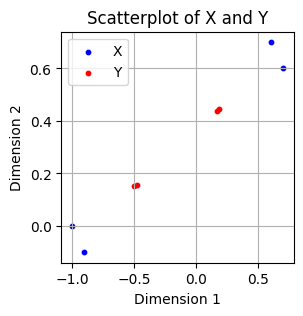

In [31]:
plt.figure(figsize=(3,3))
plt.scatter(X[:, 0], X[:, 1], color='blue', s=10, label='X')
plt.scatter(Y[:, 0], Y[:, 1], color='red', s=10, label='Y')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatterplot of X and Y')
plt.legend()
plt.grid(True)
plt.show()

As we can see, the effect of this transformation is to make similar embeddings even more similar. 

**Exercise**

<details>
<summary>How does that help with learning?
</summary>
If similar words become more similar, it is more likely that whatever we learn for one of them is also going to be learned for the other. Also, this proximity depends on context, that is, in other contexts, these words could be moved so that they are closer to other words.
</details>



## Query, key, value

The attention mechanism was observed to be similar to a search with a query in in a key-value database. In this type of database, we give relevance to values based on the similarity between a query and a key. Because of that, the output is actually calculated using three separated inputs, as in:

$$
Y = \text{softmax} (QK^T/\sqrt{D})V.
$$

An important step here is to allow three different inputs, instead of forcing $Q=K=V$. Thus, we have inputs $X_q, X_k, X_v$. Also, the paper proposed making linear projections of the inputs to obtain $Q,K,V$, that is:

$$
Q = X_qW_q^T\\
K = X_kW_k^T\\
V = X_vW_v^T,
$$

and this allows learning the weight matrices $W_q, W_k, W_v$.

**Exercise**

<details>
<summary>How does that help in the classification process?
</summary>
By applying these different linear transformations, we change the alignments between words, which in turn changes which words are "closer" to the others and which words would be grouped together in the calculation of $Y$.
</details>

## Example: when relative words matter

Check this example. Looking at this database, why does one classifier fail, but the other succeeds?

In [32]:
# Dataset
X = torch.tensor([
    [0, 1, 2],
    [0, 3, 2],
    [4, 3, 2],
    [4, 1, 2],
])

y = torch.tensor([
    [1.],
    [0.],
    [1.],
    [0.],
])

In [33]:
class ClassifierWithMHAPositionEncoding(nn.Module):
    def __init__(self, vocab_size, seq_len, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.position_embedding = nn.Embedding(
            num_embeddings=seq_len,  # Assuming max sequence length of 100
            embedding_dim=embedding_dim
        )
        self.mhe = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=1,
            batch_first=True
        )
        self.r1 = ResidualBlock(embedding_dim)
        self.clf = nn.Linear(embedding_dim, 1)
        
    def forward(self, x):
        pos_enc = self.position_embedding(torch.arange(x.size(1)))
        x_embeddings = self.embedding(x)
        x = x_embeddings + pos_enc
        x_ = self.mhe(x, x, x)[0]
        x = x_ + x
        x = self.r1(x)
        x = torch.mean(x, dim=1)
        x = self.clf(x)
        return x

Entering loop


100%|██████████| 1000/1000 [00:04<00:00, 202.39it/s]


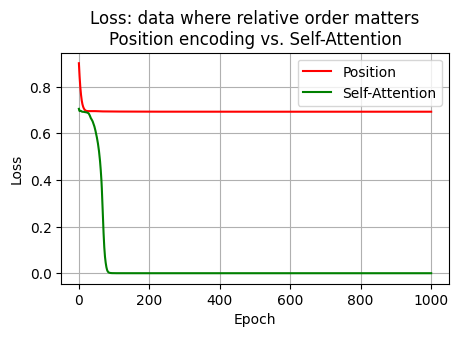

In [34]:
model_baseline = ClassifierWithPositionEncoding(vocab_size=5, seq_len=3, embedding_dim=2)
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=1e-2) # lr is the learning rate - this is our alpha
model_mha = ClassifierWithMHAPositionEncoding(vocab_size=5, seq_len=3, embedding_dim=2)
optimizer_mha = optim.Adam(model_mha.parameters(), lr=1e-2) # lr is the learning rate - this is our alpha

print("Entering loop")
# And now, this is the training loop:
losses_bl = []
losses_mha = []
for epoch in tqdm(range(1000)):
    loss1 = train_one_epoch(model_baseline, optimizer_baseline, X, y)
    loss2 = train_one_epoch(model_mha, optimizer_mha, X, y)
    losses_bl.append(loss1)
    losses_mha.append(loss2)

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(losses_bl) + 1), losses_bl, 'r', label='Position')
plt.plot(range(1, len(losses_mha) + 1), losses_mha, 'g', label='Self-Attention')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss: data where relative order matters\nPosition encoding vs. Self-Attention')
plt.grid(True)
plt.legend()
plt.show()

## Exercise: ablation study

Remove the positional encoding from the multihead attention. What happens to the loss? Why does that happen?

# Case study

Take a look at the dataset below. Explain the results shown in the figure. Why does each model reach a different loss?

In [35]:
# Dataset
X = torch.tensor([
    [0, 1, 2],
    [0, 3, 2],
    [4, 3, 2],
    [4, 1, 2],
    [0, 1, 2],
    [2, 1, 0],
    [1, 3, 4],
    [4, 3, 1],
])

y = torch.tensor([
    [1.],
    [0.],
    [1.],
    [0.],
    [1.],
    [0.],
    [1.],
    [0.],
])


Entering loop


100%|██████████| 500/500 [00:03<00:00, 147.91it/s]


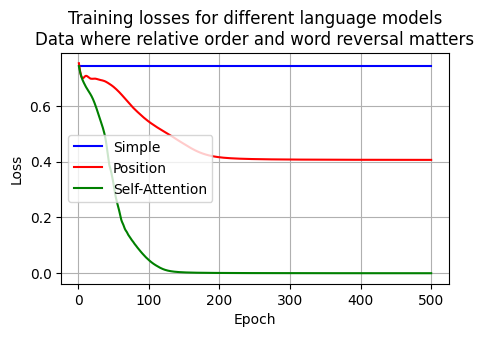

In [36]:
model_baseline = ClassifierWithPositionEncoding(vocab_size=5, seq_len=3, embedding_dim=2)
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=1e-2) # lr is the learning rate - this is our alpha
model_mha = ClassifierWithMHAPositionEncoding(vocab_size=5, seq_len=3, embedding_dim=2)
optimizer_mha = optim.Adam(model_mha.parameters(), lr=1e-2) # lr is the learning rate - this is our alpha
model_simple = MeanClassifier(vocab_size=5, embedding_dim=2)
optimizer_simple = optim.Adam(model.parameters(), lr=1e-2) # lr is the learning rate - this is our alpha

print("Entering loop")
# And now, this is the training loop:
losses_bl = []
losses_mha = []
losses_simple = []
for epoch in tqdm(range(500)):
    loss1 = train_one_epoch(model_baseline, optimizer_baseline, X, y)
    loss2 = train_one_epoch(model_mha, optimizer_mha, X, y)
    loss3 = train_one_epoch(model_simple, optimizer_simple, X, y)
    losses_bl.append(loss1)
    losses_mha.append(loss2)
    losses_simple.append(loss3)

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(losses_simple) + 1), losses_simple, 'b', label='Simple')
plt.plot(range(1, len(losses_bl) + 1), losses_bl, 'r', label='Position')
plt.plot(range(1, len(losses_mha) + 1), losses_mha, 'g', label='Self-Attention')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training losses for different language models\nData where relative order and word reversal matters')
plt.grid(True)
plt.legend()
plt.show()

## Practice: Multi-head attention

It was observed that using multiple attention mechanisms in parallel can improve final results. Thus, the idea is to yield the same input to multiple attention mechanisms, and then cocatenate the results. This is somewhat ingenious, at it allows giving attention to different parts of the input for different reasons.

The pytorch [API for a multihead attention layer](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) is very simple:

    mhe = nn.MultiheadAttention(embed_dim, num_heads)

where `embed_dim` must be divisible by `num_heads`.

Use the documentation and add a curve to the case study with a 2-head attention block (instead of the single attention block we are using). How can we combine the attention spanned by each of the heads?

